In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Requirement already up-to-date: keras_applications==1.0.6 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages
Requirement already up-to-date: keras==2.2.4 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.9.1 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras_applications==1.0.6)
Requirement already up-to-date: h5py in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras_applications==1.0.6)
Requirement already up-to-date: six>=1.9.0 in /home/jovyan/modelarts-sdk (from keras==2.2.4)
Requirement already up-to-date: keras-preprocessing>=1.0.5 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
Requirement already up-to-date: scipy>=0.14 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
Requirement already up-to-date: pyyaml in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
You are using pip version 9.0.1, however 

In [2]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
        bucket_path="modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz",
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image

Using TensorFlow backend.
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/python36_tf/lib/python3.6

In [4]:
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [5]:
(x_train, y_train) = load_data()
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [6]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [7]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [8]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [9]:
base_model = VGG16(weights=None, include_top=False)

In [10]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

In [11]:
import keras 
#SDG优化器
epochs = 36
opt = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
callbacks = []

In [15]:
history_rmsprop = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36
18750/18750 [==============================] - 165s 9ms/step - loss: 0.6931 - acc: 0.5070 - val_loss: 0.6928 - val_acc: 0.5152
Epoch 2/36
18750/18750 [==============================] - 150s 8ms/step - loss: 0.6925 - acc: 0.5209 - val_loss: 0.6918 - val_acc: 0.5267
Epoch 3/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6905 - acc: 0.5497 - val_loss: 0.6878 - val_acc: 0.5715
Epoch 4/36
18750/18750 [==============================] - 151s 8ms/step - loss: 0.6842 - acc: 0.5638 - val_loss: 0.6706 - val_acc: 0.5928
Epoch 5/36
18750/18750 [==============================] - 150s 8ms/step - loss: 0.6742 - acc: 0.5771 - val_loss: 0.6600 - val_acc: 0.5994
Epoch 6/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6629 - acc: 0.5886 - val_loss: 0.6594 - val_acc: 0.5917
Epoch 7/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6604 - acc: 0.5881 - val_loss: 0.6447 - v

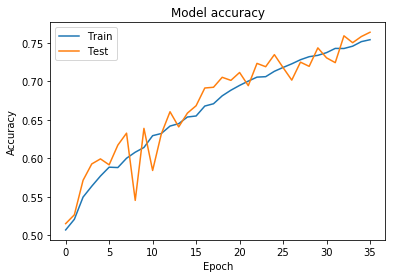

In [18]:
import matplotlib.pyplot as plt
plt.plot(history_rmsprop.history['acc'])
plt.plot(history_rmsprop.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

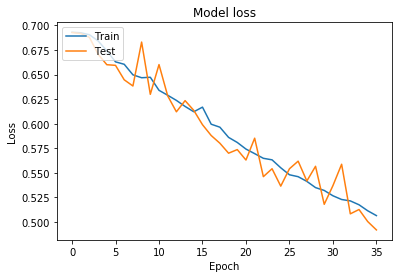

In [20]:
plt.plot(history_rmsprop.history['loss'])
plt.plot(history_rmsprop.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
import keras 
#SDG优化器 带动量和衰减量的优化方式下
epochs = 36
opt = keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
callbacks = []

In [12]:
history_sdg = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36
18750/18750 [==============================] - 159s 8ms/step - loss: 0.6934 - acc: 0.5036 - val_loss: 0.6939 - val_acc: 0.5019
Epoch 2/36
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6930 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5019
Epoch 3/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6925 - acc: 0.5114 - val_loss: 0.6911 - val_acc: 0.5018
Epoch 4/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6889 - acc: 0.5341 - val_loss: 0.6893 - val_acc: 0.5382
Epoch 5/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6791 - acc: 0.5630 - val_loss: 0.6655 - val_acc: 0.5982
Epoch 6/36
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6583 - acc: 0.5986 - val_loss: 0.6629 - val_acc: 0.6091
Epoch 7/36
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6211 - acc: 0.6589 - val_loss: 0.6062 - v

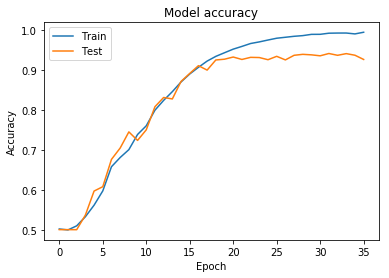

In [14]:
import matplotlib.pyplot as plt
plt.plot(history_sdg.history['acc'])
plt.plot(history_sdg.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

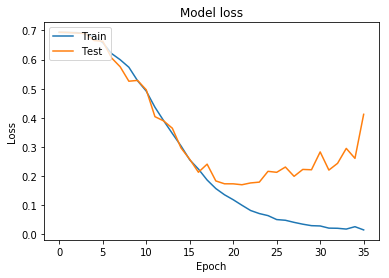

In [15]:
plt.plot(history_sdg.history['loss'])
plt.plot(history_sdg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
import keras 
#SDG优化器 带动量和衰减量的优化方式下, 学习率减少
epochs = 36
opt = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = []

In [12]:
history_sdg2 = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36
18750/18750 [==============================] - 165s 9ms/step - loss: 0.6931 - acc: 0.5024 - val_loss: 0.6931 - val_acc: 0.4994
Epoch 2/36
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5028 - val_loss: 0.6930 - val_acc: 0.5082
Epoch 3/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6930 - acc: 0.5236 - val_loss: 0.6930 - val_acc: 0.5274
Epoch 4/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6929 - acc: 0.5116 - val_loss: 0.6929 - val_acc: 0.5248
Epoch 5/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6929 - acc: 0.5425 - val_loss: 0.6928 - val_acc: 0.5886
Epoch 6/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6928 - acc: 0.5444 - val_loss: 0.6928 - val_acc: 0.5518
Epoch 7/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6927 - acc: 0.5335 - val_loss: 0.6927 - v

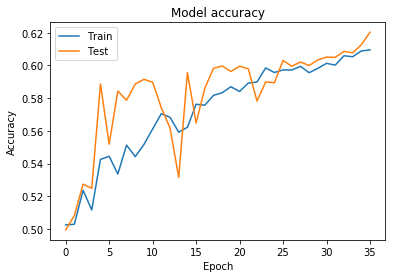

In [14]:
plt.plot(history_sdg2.history['acc'])
plt.plot(history_sdg2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

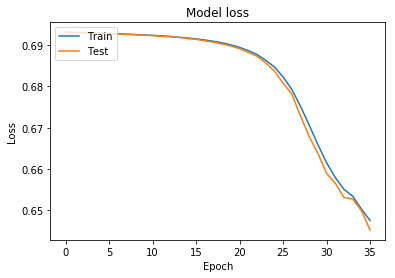

In [15]:
plt.plot(history_sdg2.history['loss'])
plt.plot(history_sdg2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
import keras 
#RMSprop优化器 
epochs = 36
opt = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
callbacks = []

In [12]:
historyRMSprop = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36
18750/18750 [==============================] - 161s 9ms/step - loss: 0.6816 - acc: 0.5724 - val_loss: 0.6298 - val_acc: 0.6342
Epoch 2/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.6400 - acc: 0.6404 - val_loss: 0.6442 - val_acc: 0.6413
Epoch 3/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.5933 - acc: 0.6900 - val_loss: 0.5610 - val_acc: 0.7286
Epoch 4/36
18750/18750 [==============================] - 153s 8ms/step - loss: 0.5571 - acc: 0.7221 - val_loss: 0.5289 - val_acc: 0.7454
Epoch 5/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.5151 - acc: 0.7554 - val_loss: 0.5212 - val_acc: 0.7398
Epoch 6/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.4664 - acc: 0.7854 - val_loss: 0.4598 - val_acc: 0.7766
Epoch 7/36
18750/18750 [==============================] - 154s 8ms/step - loss: 0.4158 - acc: 0.8109 - val_loss: 0.3509 - v

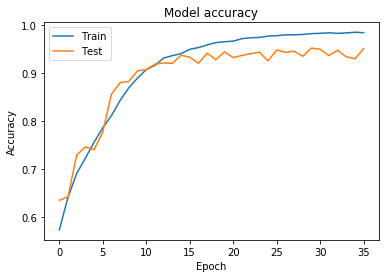

In [16]:
import matplotlib.pyplot as plt
plt.plot(historyRMSprop.history['acc'])
plt.plot(historyRMSprop.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

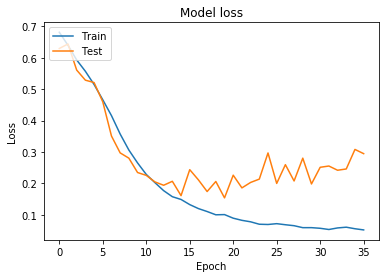

In [17]:
plt.plot(historyRMSprop.history['loss'])
plt.plot(historyRMSprop.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
import keras 
#Adam优化器 
epochs = 36
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
callbacks = []

In [12]:
 history_adam = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36
18750/18750 [==============================] - 162s 9ms/step - loss: 0.6931 - acc: 0.4937 - val_loss: 0.6931 - val_acc: 0.5019
Epoch 2/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6900 - acc: 0.5236 - val_loss: 0.6808 - val_acc: 0.5670
Epoch 3/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6669 - acc: 0.5948 - val_loss: 0.6280 - val_acc: 0.6506
Epoch 4/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6008 - acc: 0.6762 - val_loss: 0.5772 - val_acc: 0.6978
Epoch 5/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.5440 - acc: 0.7281 - val_loss: 0.5153 - val_acc: 0.7526
Epoch 6/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.4794 - acc: 0.7743 - val_loss: 0.6020 - val_acc: 0.7130
Epoch 7/36
18750/18750 [==============================] - 156s 8ms/step - loss: 0.4162 - acc: 0.8118 - val_loss: 0.4056 - v

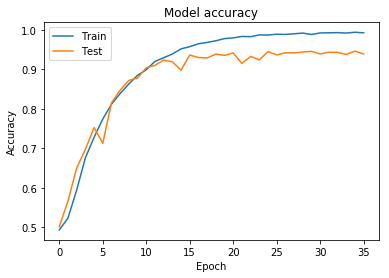

In [14]:

plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

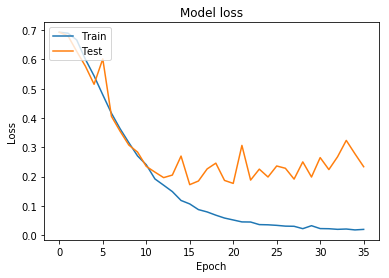

In [15]:
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
import math
import keras
from keras.callbacks import LearningRateScheduler
#sdg 优化器 手动速率
epochs = 40
loop = 10
def step_decay(epoch):
    lrate = 0.001
    base_lrate = 0.01     #初始学习率
    min_lrate = 0.0001
    lv = epoch // loop
    epoch = epoch - loop * lv
    lrate = 0.5 * (base_lrate - min_lrate) * (1 + math.cos( epoch/loop * 3.14 )) 
    return lrate
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
lr = LearningRateScheduler(step_decay, 1) 
callbacks = [lr]

In [23]:
 history_sdgX = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0099.
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6927 - acc: 0.5167 - val_loss: 0.6922 - val_acc: 0.5043
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0096579733136807.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6911 - acc: 0.5500 - val_loss: 0.6888 - val_acc: 0.5763
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.008955560695890761.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6844 - acc: 0.5641 - val_loss: 0.7090 - val_acc: 0.5000
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.007861450065140307.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6746 - acc: 0.5734 - val_loss: 0.6717 - val_acc: 0.5774
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.006482632

Epoch 38/40

Epoch 00038: LearningRateScheduler setting learning rate to 0.002044929404806897.
18750/18750 [==============================] - 155s 8ms/step - loss: 0.5015 - acc: 0.7585 - val_loss: 0.5443 - val_acc: 0.7317
Epoch 39/40

Epoch 00039: LearningRateScheduler setting learning rate to 0.0009490762350169139.
18750/18750 [==============================] - 155s 8ms/step - loss: 0.4888 - acc: 0.7680 - val_loss: 0.5141 - val_acc: 0.7494
Epoch 40/40

Epoch 00040: LearningRateScheduler setting learning rate to 0.0002444676393905681.
18750/18750 [==============================] - 154s 8ms/step - loss: 0.4822 - acc: 0.7732 - val_loss: 0.4931 - val_acc: 0.7654


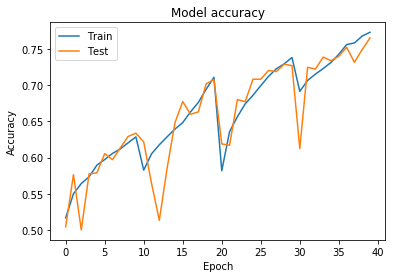

In [26]:
import matplotlib.pyplot as plt
plt.plot(history_sdgX.history['acc'])
plt.plot(history_sdgX.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

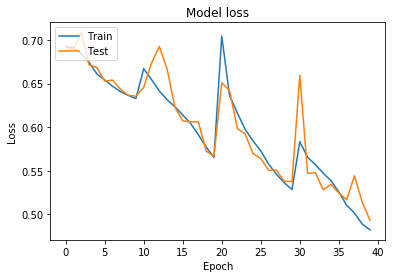

In [27]:
plt.plot(history_sdgX.history['loss'])
plt.plot(history_sdgX.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
import math
import keras
from keras.callbacks import LearningRateScheduler
#sdg 最大学习率测试
loop = 5
epochs = 36
def step_test(epoch):
    lrate = 0.001
    start_lrate = 1e-7     #初始学习率
    lv =  epoch // loop
    epoch = epoch%loop 
    lrate = math.pow(10, lv) * start_lrate + math.pow(10, lv) * start_lrate * 1.6 * epoch
    return lrate
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
lr = LearningRateScheduler(step_test, 1) 
callbacks = [lr]

In [18]:
 history_lrtest = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/36

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-07.
18750/18750 [==============================] - 156s 8ms/step - loss: 0.6931 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 2/36

Epoch 00002: LearningRateScheduler reducing learning rate to 2.6e-07.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 3/36

Epoch 00003: LearningRateScheduler reducing learning rate to 4.2e-07.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 4/36

Epoch 00004: LearningRateScheduler reducing learning rate to 5.800000000000001e-07.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6931 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 5/36

Epoch 00005: LearningRateScheduler reducing learning rate to 7.4e-07.
18750/18750 [========

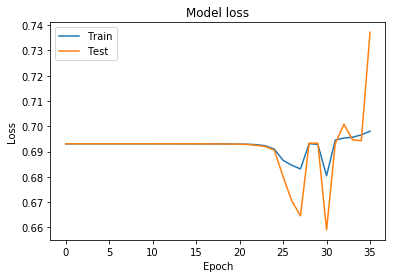

In [21]:
import matplotlib.pyplot as plt
plt.plot(history_lrtest.history['loss'])
plt.plot(history_lrtest.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
import math
import keras
from keras.callbacks import LearningRateScheduler
#sdg 优化器 手动速率
epochs = 40
loop = 18
def step_decay(epoch):
    lrate = 0.01
    max_lrate = 0.1     #初始学习率
    min_lrate = 0.01
    lv = epoch // loop
    if lv is 0:
        epoch = epoch + 1
        lrate = max_lrate / loop * epoch
    if lv is 1:
        epoch = epoch - loop * lv
        lrate = 0.5 * (max_lrate - min_lrate / 2 ) * ( 1.2 + math.cos( epoch/loop * 3.14 )) 
    if lv is 2:
        drop = 0.5
        epoch = epoch - loop * lv
        lrate = min_lrate * math.pow(drop, (1 + epoch)/4)
    return lrate
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
lr = LearningRateScheduler(step_decay, 1) 
callbacks = [lr]

In [12]:
 history_1cycle = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=32, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.005555555555555556.
18750/18750 [==============================] - 158s 8ms/step - loss: 0.6930 - acc: 0.5095 - val_loss: 0.6929 - val_acc: 0.4981
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.011111111111111112.
18750/18750 [==============================] - 153s 8ms/step - loss: 0.6925 - acc: 0.5182 - val_loss: 0.6917 - val_acc: 0.5072
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.016666666666666666.
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6902 - acc: 0.5327 - val_loss: 0.6832 - val_acc: 0.6080
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.022222222222222223.
18750/18750 [==============================] - 152s 8ms/step - loss: 0.6836 - acc: 0.5537 - val_loss: 0.6868 - val_acc: 0.5430
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rat

Epoch 38/40

Epoch 00038: LearningRateScheduler setting learning rate to 0.007071067811865476.
18750/18750 [==============================] - 152s 8ms/step - loss: 4.4676e-04 - acc: 0.9999 - val_loss: 0.4855 - val_acc: 0.9286
Epoch 39/40

Epoch 00039: LearningRateScheduler setting learning rate to 0.005946035575013605.
18750/18750 [==============================] - 153s 8ms/step - loss: 3.8883e-04 - acc: 0.9999 - val_loss: 0.4912 - val_acc: 0.9283
Epoch 40/40

Epoch 00040: LearningRateScheduler setting learning rate to 0.005.
18750/18750 [==============================] - 154s 8ms/step - loss: 3.4849e-04 - acc: 0.9999 - val_loss: 0.4964 - val_acc: 0.9290


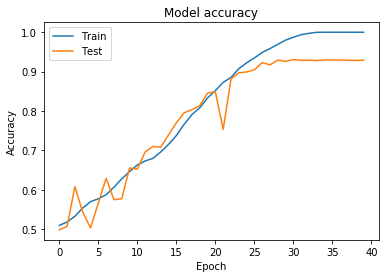

In [14]:
plt.plot(history_1cycle.history['acc'])
plt.plot(history_1cycle.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

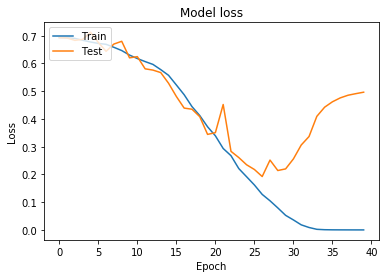

In [15]:
import matplotlib.pyplot as plt
plt.plot(history_1cycle.history['loss'])
plt.plot(history_1cycle.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()